# Storm Data Prediciton
## Group 1: Dhairya Dodia, Duncan Conley, Jameson Thomas
----------------------------------------------------------

### Step 0: Import libraries:

In [41]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

### Step 1: Load & Prep Data

In [42]:
file_path = "StormEvents_details-ftp_v1.0_d2024_c20250401.csv.gz"  # data

# Read the CSV file
df = pd.read_csv(file_path)

### --- FEATURE ENGINEER COLUMNS --- ###

# Combine BEGIN_LAT and END_LAT into a single LAT column
def combine_latitudes(row):
    if pd.notna(row['BEGIN_LAT']) and pd.notna(row['END_LAT']):
        return (row['BEGIN_LAT'] + row['END_LAT']) / 2  # LAT = Average (both present)
    elif pd.notna(row['BEGIN_LAT']):
        return row['BEGIN_LAT']  # LAT = BEGIN_LAT (END_LAT missing)
    elif pd.notna(row['END_LAT']):
        return row['END_LAT']  # LAT = END_LAT (BEGIN_LAT missing)
    else:
        return np.nan  # Return NaN (both missing)

# Combine BEGIN_LON and END_LON into a single LON column
def combine_longitudes(row):
    if pd.notna(row['BEGIN_LON']) and pd.notna(row['END_LON']):
        return (row['BEGIN_LON'] + row['END_LON']) / 2  # LON = Average (both present)
    elif pd.notna(row['BEGIN_LON']):
        return row['BEGIN_LON']  # LON = BEGIN_LON (END_LON missing)
    elif pd.notna(row['END_LON']):
        return row['END_LON']  # LON = END_LON (BEGIN_LON missing)
    else:
        return np.nan  # Return NaN (both missing)

# Combine BEGIN_DATE_TIME and END_DATE_TIME into a single ELAPSED_TIME_MIN column
def calculate_elapsed_minutes(row):
    # Convert the strings to datetime objects using the correct format
    begin_time = pd.to_datetime(row['BEGIN_DATE_TIME'], format="%d-%b-%y %H:%M:%S", errors='coerce')
    end_time = pd.to_datetime(row['END_DATE_TIME'], format="%d-%b-%y %H:%M:%S", errors='coerce')
    
    # If either conversion fails, return NaN
    if pd.isna(begin_time) or pd.isna(end_time):
        return np.nan

    # Compute the elapsed time in minutes and return as an integer
    elapsed = end_time - begin_time
    return int(elapsed.total_seconds() // 60)

def convert_damage(value):
    if pd.isna(value):
        return 0  # Handle NaN values
    value = str(value).upper().strip()  # Ensure the value is uppercase and clean
    if value.endswith('K'):  # Thousands
        try:
            return float(value[:-1]) * 1e3
        except ValueError:
            return 0
    # Optionally, handle other cases (e.g., values ending in 'M' for millions)
    try:
        return float(value)
    except ValueError:
        return 0
    
###############################################
# Define a function to process each chunk of data
###############################################

def process_chunk(chunk):
    # Drop rows where DAMAGE_PROPERTY is missing
    chunk = chunk[pd.notna(chunk['DAMAGE_PROPERTY'])]
    
    # Convert damage values (DAMAGE_PROPERTY and DAMAGE_CROPS)
    chunk['DAMAGE_PROPERTY'] = chunk['DAMAGE_PROPERTY'].apply(convert_damage)
    chunk['DAMAGE_CROPS'] = chunk['DAMAGE_CROPS'].apply(convert_damage)
    # Ensure numeric conversion (errors coerced to NaN)
    chunk['DAMAGE_PROPERTY'] = pd.to_numeric(chunk['DAMAGE_PROPERTY'], errors='coerce')
    
    # Feature engineering for spatial and time columns
    chunk['LAT'] = chunk.apply(combine_latitudes, axis=1)
    chunk['LON'] = chunk.apply(combine_longitudes, axis=1)
    chunk['ELAPSED_TIME_MIN'] = chunk.apply(calculate_elapsed_minutes, axis=1)
    
    # Drop columns that are not used in the model.
    drop_columns = [
        'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'EPISODE_ID', 'EVENT_ID', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE',
        'DATA_SOURCE', 'SOURCE', 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
        'DEATHS_INDIRECT', 'FLOOD_CAUSE', 'MONTH_NAME', 'BEGIN_DAY', 'BEGIN_TIME', 'END_DAY', 'END_TIME',
        'CZ_NAME', 'WFO', 'CZ_TIMEZONE', 'BEGIN_RANGE', 'BEGIN_DATE_TIME', 'END_DATE_TIME',
        'TOR_OTHER_CZ_NAME', 'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_WFO',
        'END_RANGE', 'BEGIN_AZIMUTH', 'END_AZIMUTH', 'BEGIN_LON', 'END_LON', 'BEGIN_LAT', 'END_LAT', 
        'BEGIN_LOCATION', 'END_LOCATION', 'BEGIN_YEARMONTH', 'END_YEARMONTH', 'STATE', 'STATE_FIPS', 
        'YEAR', 'CATEGORY', 'MAGNITUDE_TYPE'
    ]
    for col in drop_columns:
        if col in chunk.columns:
            chunk = chunk.drop(columns=col)
    
    # Create target variable DAMAGE_CATEGORY using quantile-based binning.
    # Here, we use qcut with q=4 and assign two labels as an example.
    # Adjust labels as needed.
    chunk['DAMAGE_CATEGORY'] = pd.qcut(
        chunk['DAMAGE_PROPERTY'], 
        q=4, 
        labels=['low', 'high'], 
        duplicates='drop'
    )
    
    # Select only the numeric features for X.
    numeric_columns = chunk.select_dtypes(include=[np.number]).columns
    # Exclude original damage columns from features.
    X = chunk[numeric_columns].drop(columns=['DAMAGE_PROPERTY', 'DAMAGE_CROPS'])
    y = chunk['DAMAGE_CATEGORY']
    
    return X, y

###############################################
# Process multiple CSV files in low-memory mode
###############################################

def process_files(file_pattern, chunksize=100000):
    X_list = []
    y_list = []
    
    # Get the list of files matching the given pattern.
    file_list = sorted(glob.glob(file_pattern))
    for file in file_list:
        print(f"Processing file: {file}")
        # Process each file in chunks.
        for chunk in pd.read_csv(file, chunksize=chunksize):
            X_chunk, y_chunk = process_chunk(chunk)
            X_list.append(X_chunk)
            y_list.append(y_chunk)
    
    # Concatenate all processed chunks.
    X_full = pd.concat(X_list, ignore_index=True)
    y_full = pd.concat(y_list, ignore_index=True)
    
    return X_full, y_full




# Set the file pattern to include all .csv files from 1950 to 2024.
# Adjust the file path and pattern below to match your directory structure.
file_pattern = "StormEvents_details-ftp_v1.0_d*.csv.gz"

# Process the files using the low-RAM chunk method.
X_full, y_full = process_files(file_pattern, chunksize=100000)
print("Final dataset size:", X_full.shape, y_full.shape)



# Drop all rows in which there is no DAMAGE_PROPERTY
df = df[pd.notna(df['DAMAGE_PROPERTY'])]

# Convert damage values to numeric
df['DAMAGE_PROPERTY'] = df['DAMAGE_PROPERTY'].apply(convert_damage)
df['DAMAGE_CROPS'] = df['DAMAGE_CROPS'].apply(convert_damage)
df['DAMAGE_PROPERTY'] = pd.to_numeric(df['DAMAGE_PROPERTY'], errors='coerce')

# Create new columns from longitudes, latitudes, and elapsed time
df['LAT'] = df.apply(combine_latitudes, axis=1)
df['LON'] = df.apply(combine_longitudes, axis=1)
df['ELAPSED_TIME_MIN'] = df.apply(calculate_elapsed_minutes, axis=1)


# Keep only rows where 'EVENT_TYPE' is 'Tornado'
df = df[df['EVENT_TYPE'] == 'Tornado']

# Verify the result
print(df['EVENT_TYPE'].unique())
print(f"Number of rows after filtering: {len(df)}")

# Drop unnecessary columns
df = df.drop(columns=['EVENT_TYPE'])

# Verify the result
#print(df.columns)
df = df.drop(columns=[
    'CZ_TYPE', 'CZ_FIPS', 'EPISODE_ID', 'EVENT_ID', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE',
    'DATA_SOURCE', 'SOURCE', 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
    'DEATHS_INDIRECT', 'FLOOD_CAUSE', 'MONTH_NAME', 'BEGIN_DAY', 'BEGIN_TIME', 'END_DAY', 'END_TIME',
    'CZ_NAME', 'WFO', 'CZ_TIMEZONE', 'BEGIN_RANGE', 'BEGIN_DATE_TIME', 'END_DATE_TIME',
    'TOR_OTHER_CZ_NAME', 'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_WFO',
    'END_RANGE', 'BEGIN_AZIMUTH', 'END_AZIMUTH', 'BEGIN_LON', 'END_LON', 'BEGIN_LAT', 'END_LAT', 'BEGIN_LOCATION', 'END_LOCATION',
    'BEGIN_YEARMONTH', 'END_YEARMONTH', 'STATE', 'STATE_FIPS', 'YEAR', 'CATEGORY', 'MAGNITUDE_TYPE'
])

# Print columns used
print(df.columns)


Processing file: StormEvents_details-ftp_v1.0_d2024_c20250401.csv.gz


C:\Users\jazzy\AppData\Local\Temp\ipykernel_7352\1336968336.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['DAMAGE_PROPERTY'] = chunk['DAMAGE_PROPERTY'].apply(convert_damage)
C:\Users\jazzy\AppData\Local\Temp\ipykernel_7352\1336968336.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['DAMAGE_CROPS'] = chunk['DAMAGE_CROPS'].apply(convert_damage)
C:\Users\jazzy\AppData\Local\Temp\ipykernel_7352\1336968336.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Final dataset size: (54862, 6) (54862,)
['Tornado']
Number of rows after filtering: 1774
Index(['DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'MAGNITUDE', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'LAT', 'LON', 'ELAPSED_TIME_MIN'],
      dtype='object')


In [43]:
# Create the damage category using pd.cut; include the lowest value in the first bin.
# bins = np.linspace(df['DAMAGE_PROPERTY'].min(), df['DAMAGE_PROPERTY'].max(), num=4)
# labels = ['low', 'medium', 'high']
# df['DAMAGE_CATEGORY'] = pd.cut(df['DAMAGE_PROPERTY'], bins=bins, labels=labels, include_lowest=True)
bins = np.percentile(df['DAMAGE_PROPERTY'], [0, 50, 100])
print("Bin edges:", bins)

# Correct number of labels for 4 bins
df['DAMAGE_CATEGORY'] = pd.qcut(
    df['DAMAGE_PROPERTY'], 
    q=2,  # Number of quantiles
    labels=['low', 'high'],  # 4 labels for 4 quantiles
    duplicates='drop'  # Drop duplicate bin edges if necessary
)

# Verify the result
print(df['DAMAGE_CATEGORY'].value_counts())


# --- ENCODE CATEGORICAL VARIABLES --- #
# List of categorical columns that you want to include as features
categorical_columns = [ 'MAGNITUDE_TYPE', 'TOR_F_SCALE']

# Use get_dummies to convert categorical columns to dummy/indicator variables.
#encoded_cats = pd.get_dummies(df[categorical_columns], drop_first=True)

# --- PREPARE FEATURE MATRIX --- #
# Select the numeric columns and drop any that are not desired as features.
numeric_columns = df.select_dtypes(include=[np.number]).columns
X_numeric = df[numeric_columns].drop(columns=['DAMAGE_PROPERTY', 'DAMAGE_CROPS'])

# Combine numeric features with the encoded categorical features.
#X_full = pd.concat([X_numeric, encoded_cats], axis=1)

# Impute missing values in the feature matrix
imputer = SimpleImputer(strategy='median')
#

# The target remains your damage category.
y = df['DAMAGE_CATEGORY'].values

# Check for NaN values in the feature matrix
#print("NaNs in X after imputation:", np.isnan(X_full).any())

# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# Confirm that there are no NaN values in the splits.
print("NaNs in X_train:", np.isnan(X_train).any())
print("NaNs in X_test:", np.isnan(X_test).any())

Bin edges: [0.e+00 5.e+02 6.e+06]
DAMAGE_CATEGORY
low     889
high    885
Name: count, dtype: int64
NaNs in X_train: MAGNITUDE            True
TOR_LENGTH          False
TOR_WIDTH           False
LAT                 False
LON                 False
ELAPSED_TIME_MIN    False
dtype: bool
NaNs in X_test: MAGNITUDE            True
TOR_LENGTH          False
TOR_WIDTH           False
LAT                 False
LON                 False
ELAPSED_TIME_MIN    False
dtype: bool


# Create Decision Tree


Accuracy: 0.6985915492957746
Classification Report:
               precision    recall  f1-score   support

        high       0.68      0.74      0.71       176
         low       0.72      0.66      0.69       179

    accuracy                           0.70       355
   macro avg       0.70      0.70      0.70       355
weighted avg       0.70      0.70      0.70       355



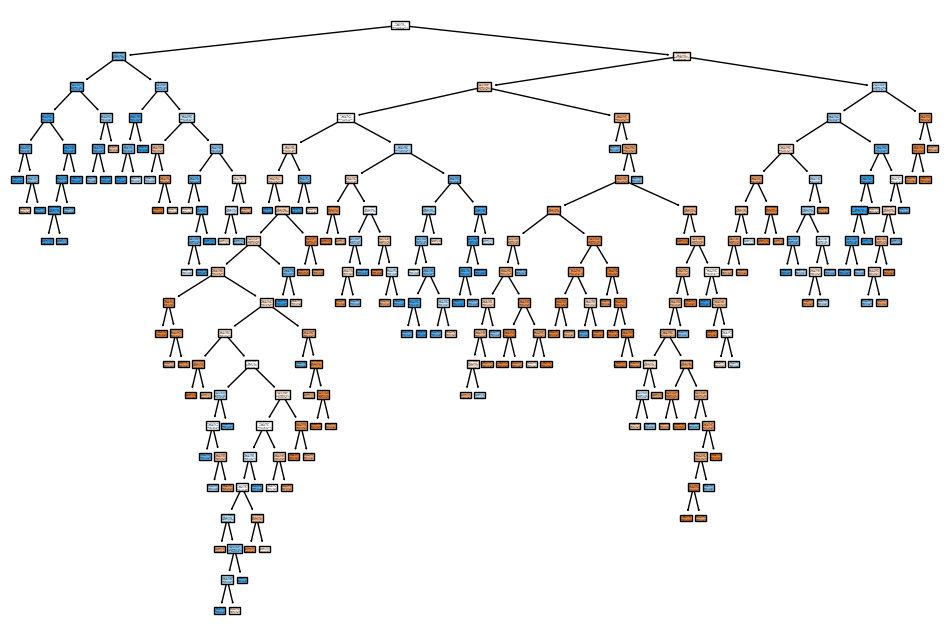

In [44]:
# Train the Decision Tree Classifier.
clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=7)
clf.fit(X_train, y_train)

# Predict on the test set and evaluate the model.
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Visualize the decision tree.
plt.figure(figsize=(12, 8))

# For plotting, combine feature names for numeric and dummy variables.
numeric_feature_names = X_numeric.columns.tolist()
#categorical_feature_names = encoded_cats.columns.tolist()
#feature_names = numeric_feature_names + categorical_feature_names

plot_tree(clf, class_names=clf.classes_, filled=True)
plt.show()

#print("Columns used in the model:" + numeric_feature_names)

columns_of_interest = ['DAMAGE_PROPERTY', 'LAT', 'LON', 'ELAPSED_TIME_MIN', 'TOR_F_SCALE', 'MAGNITUDE', 'TOR_LENGTH', 'TOR_WIDTH']
#correlation_matrix = df[columns_of_interest].corr()




# Most association with different features

# Decision Tree Regressor

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# --- Prepare Features and Target --- #
# Select numeric columns for features
numeric_columns = df.select_dtypes(include=[np.number]).columns
X = df[numeric_columns].drop(columns=['DAMAGE_PROPERTY', 'DAMAGE_CROPS']).values  # Features
y = df['DAMAGE_PROPERTY'].values  # Target variable (continuous)

# Handle missing values in X
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# Ensure there are no missing values in y
df = df.dropna(subset=['DAMAGE_PROPERTY'])
y = df['DAMAGE_PROPERTY'].values

# --- Split the Data --- #
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train the Random Forest Regressor --- #
rf_regressor = RandomForestRegressor(n_estimators=10, random_state=42, max_depth=100, min_samples_leaf=10)
rf_regressor.fit(X_train, y_train)

# --- Make Predictions --- #
y_pred = rf_regressor.predict(X_test)

# --- Evaluate the Model --- #
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 114067478640.53427
Mean Absolute Error (MAE): 87461.11710522826
R-squared (R2): 0.0012945670688696564


c:\Users\jazzy\anaconda3\Lib\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


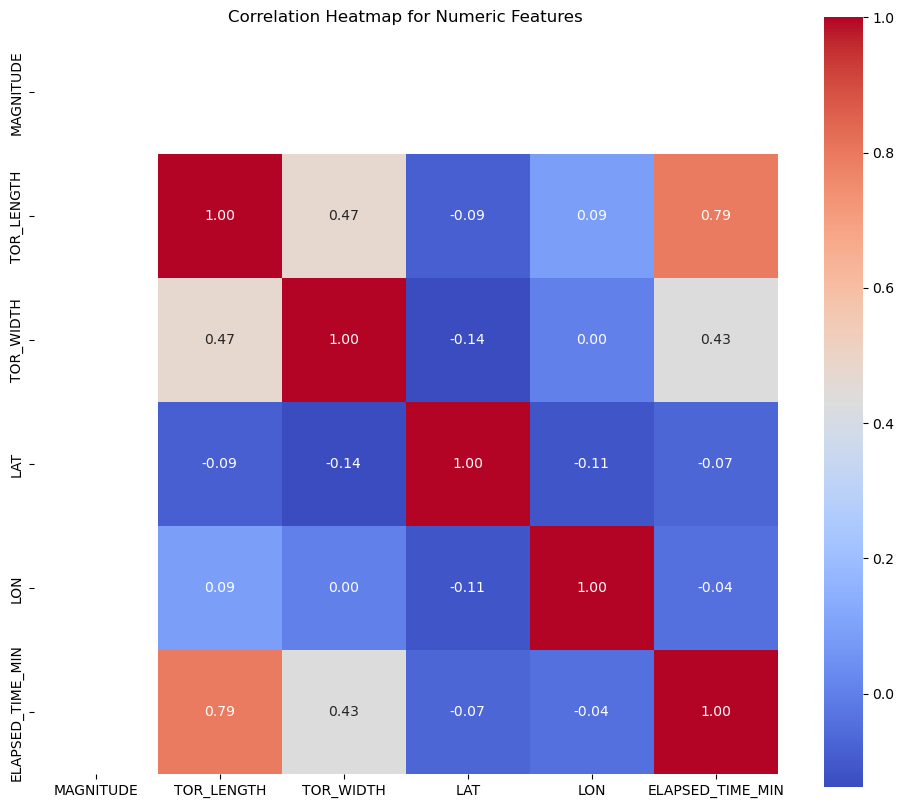

Feature Importances:
             Feature  Importance
3               LAT    0.398691
4               LON    0.299354
2         TOR_WIDTH    0.188768
1        TOR_LENGTH    0.068278
5  ELAPSED_TIME_MIN    0.044908
0         MAGNITUDE    0.000000


C:\Users\jazzy\AppData\Local\Temp\ipykernel_7352\218063781.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')


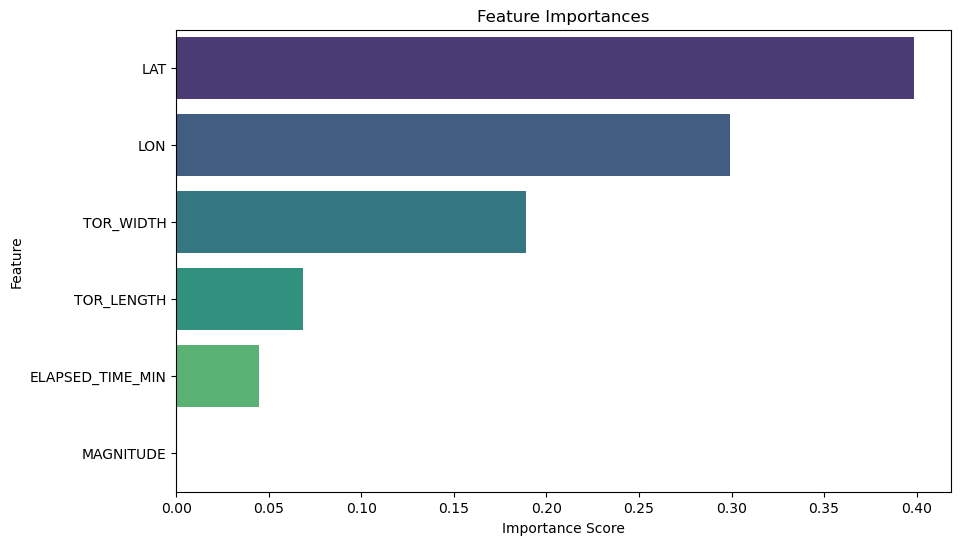

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # import seaborn for advanced plotting

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

# (Assuming you have already prepared df and performed feature engineering)
# For our purposes, we focus on the numeric features, which are in X_numeric.
# Here, we create a correlation heatmap for those features.

# Generate the correlation matrix for numeric features.
corr_matrix = X_numeric.corr()

# Set up the matplotlib figure.
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap for Numeric Features")
plt.show()

# -----------------------------------------------------
# Feature Verification using Feature Importances from a Decision Tree.
# You already split your data, trained the classifier,
# and made predictions, so now we verify which features are most important.

# Retrieve feature names from X_numeric columns (or your final feature set).
feature_names = X_numeric.columns.tolist()

# Get feature importances from the trained classifier.
importances = clf.feature_importances_

# Create a DataFrame for easy viewing.
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:\n", feature_importances)

# Plot the feature importances as a bar chart.
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

